___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://miro.medium.com/max/974/1*doaqR0rl1TZtevGrWjcS4g.png" width="500px" height="100px" />


# <font color= #8A0829> Análisis problema práctico.</font>

<Strong> Objetivos </Strong>
- Analizar un problema práctico donde se apliquen las herramientas previamente estudiadas de modelos de series de tiempo.
> Referencias: 
    > - https://www.statsmodels.org/v0.13.0/examples/notebooks/generated/statespace_sarimax_stata.html
    > - https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b
    > - https://towardsdatascience.com/autocorrelation-for-time-series-analysis-86e68e631f77
___

# Ejemplo de aplicación 1:

Los datos que se van a analizar para la construcción de un modelo se serie de tiempo tiene las siguientes características. Las entradas en la columna de fecha son números enteros que representan el número de días desde 1899-12-30. Los números enteros del período se refieren a intervalos de 30 minutos en un día de 24 horas, por lo que hay 48 para cada día. El dataset es el siguiente:

In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv'

df = pd.read_csv(url)

# Extraer fecha y hora
df['date'] = df.apply(lambda x:
    pd.Timestamp('1899-12-30') + pd.Timedelta(x['Date'], unit='D') + 
                      pd.Timedelta((x['Period'] - 1) * 30, unit='m'),
                      axis=1)

df.head()

,Date,Period,OperationalLessIndustrial,Industrial,date
0,37257,1,3535.867064,1086.132936,2002-01-01 00:00:00
1,37257,2,3383.499028,1088.500972,2002-01-01 00:30:00
2,37257,3,3655.527552,1084.472448,2002-01-01 01:00:00
3,37257,4,3510.446636,1085.553364,2002-01-01 01:30:00
4,37257,5,3294.697156,1081.302844,2002-01-01 02:00:00


Seleccionemos sólo una porción de la serie de tiempo para nuestro análisis:

In [2]:
# Tomar sólo la columna date y OperationalLessIndustrial --> y
timeseries = df[['date', 'OperationalLessIndustrial']]
timeseries.columns = ['date', 'y']

# Tomar sólo los primeros 149 días del 2012
start = pd.to_datetime('2012-01-01')
end = start + pd.Timedelta('149D')
mask = (timeseries['date'] >= start) & (timeseries['date'] <= end)
timeseries = timeseries[mask]

# Hacer un re muestreo de los datos para que queden de forma horaria (sumarlos)
timeseries = timeseries.set_index('date').resample('H').sum()

timeseries.head()

,y
date,
2012-01-01 00:00:00,7926.529376
2012-01-01 01:00:00,7901.826990
2012-01-01 02:00:00,7255.721350
2012-01-01 03:00:00,6792.503352
2012-01-01 04:00:00,6635.984460


Ahora importaré las funcionas que hemos desarrollado hasta el momento en clases previas:

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()
    
# Análisis de estacionariedad
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import statsmodels as st
import numpy as np

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
import statsmodels
print(statsmodels.__version__)

0.13.5


In [9]:
%pip install git+https://github.com/statsmodels/statsmodels

  Cloning https://github.com/statsmodels/statsmodels to /private/var/folders/f_/yfk7pckx1pvcrgw8dsns53yr0000gn/T/pip-req-build-e9vjw4f_
  Running command git clone --filter=blob:none --quiet https://github.com/statsmodels/statsmodels /private/var/folders/f_/yfk7pckx1pvcrgw8dsns53yr0000gn/T/pip-req-build-e9vjw4f_
  Resolved https://github.com/statsmodels/statsmodels to commit 3fb2b0fe4446c00e185415fd66f943e0652d0199
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for statsmodels: filename=statsmodels-0.14.0.dev727+g3fb2b0fe4-cp39-cp39-macosx_10_9_x86_64.whl size=9572793 sha256=1ec647a9fc4e6f2361c3b4f4f22eab0f25bd5cf71784ac3df3eca7d1cdaec435
  Stored in directory: /private/var/folders/f_/yfk7pckx1pvcrgw8dsns53yr0000gn/T/pip-ephem-wheel-cache-3asracjn/wheels/67/f7/05/41baa9268dfbc91927f317630a054136d3c20a80c47b2bd121
Successfully built statsmode

In [4]:
import statsmodels
print(statsmodels.__version__)

0.14.0.dev727+g3fb2b0fe4


## 1. Análisis gráfico

<AxesSubplot: xlabel='date'>

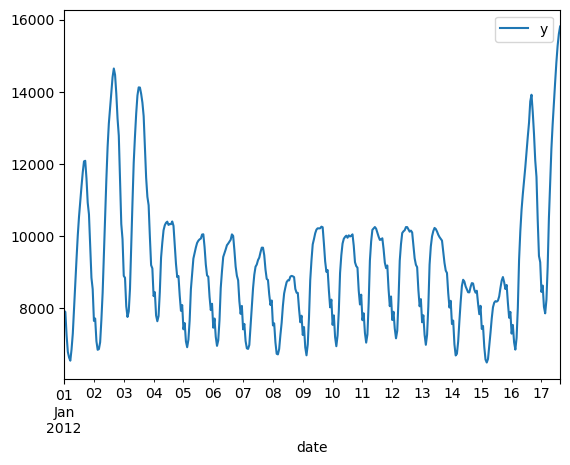

In [13]:
# Graficar la serie de tiempo

Obtener conclusiones...

## 2. Análisis de estacionalidad

## a). Analizar autocorrelación

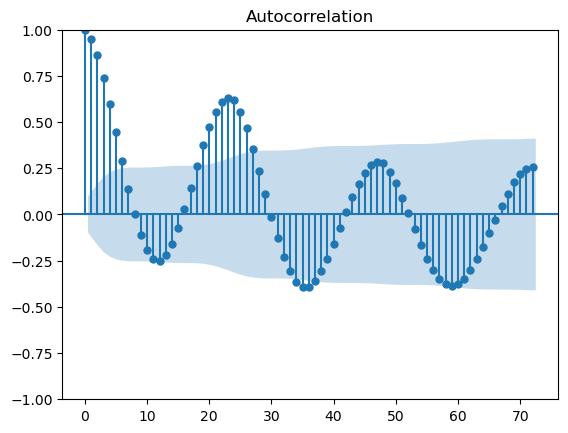

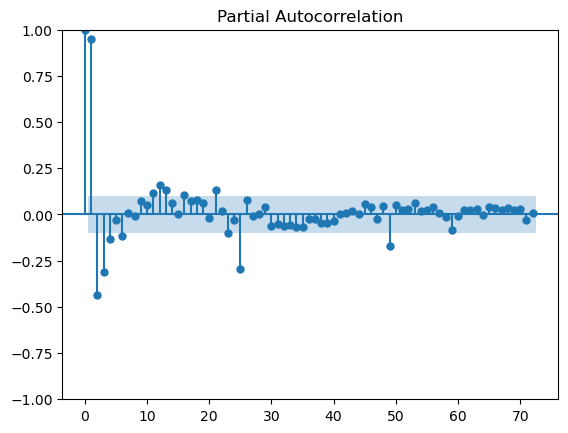

In [22]:
seasonality_data = timeseries[:400]

# Graficar ACF y PAC -> CONCLUIR

### b). Descomponer la serie de tiempo en las componentes estaciones detectadas.

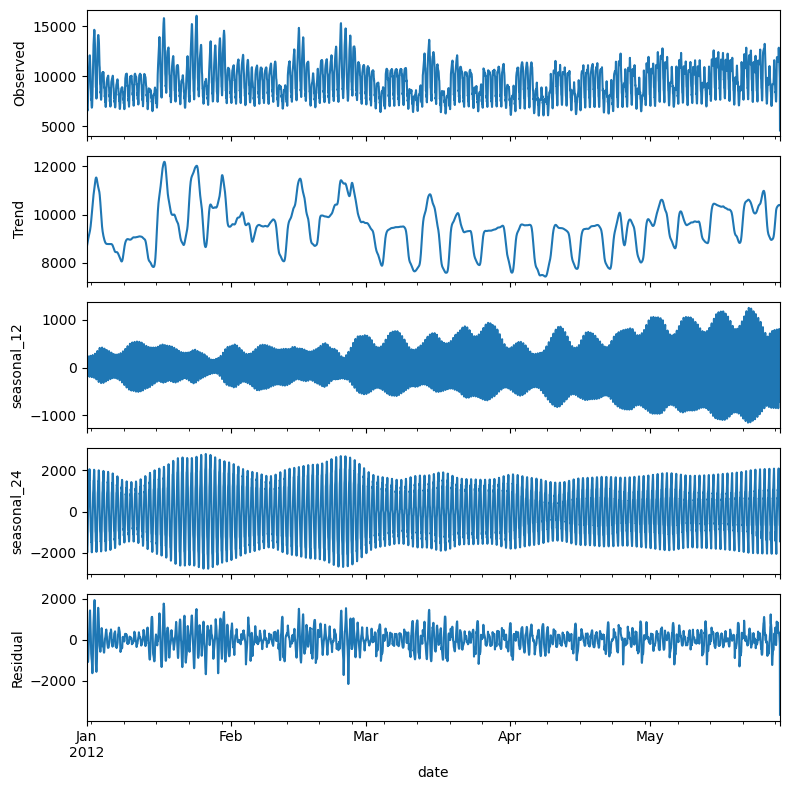

In [25]:
# Función para análisis de estacionalidad
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt

data1 = timeseries.copy()
periods_seasonality = (12, 24)

stl_kwargs = {"seasonal_deg": 0} 
model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
res2 = model.fit()

# Gráfica de descomposición
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

res2.observed.plot(ax=ax[0])
ax[0].set_ylabel('Observed')

res2.trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')

res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

res2.resid.plot(ax=ax[4])
ax[4].set_ylabel('Residual')

fig.tight_layout()

<AxesSubplot: xlabel='date'>

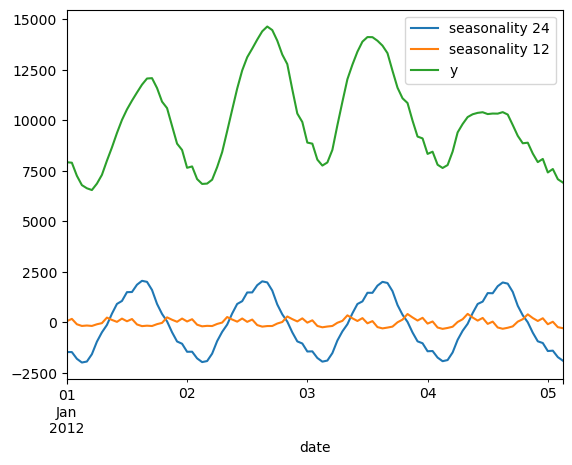

In [33]:
# Graficar datos observados con datos de estacionalidad


### c). Estacionariedad de la estacionalidad encontrada

In [36]:
# En base a la estacionalidad seleccionada, calcular la estacionariedad de dicha serie temporal
seasonality_24 = 

adf_test(seasonality_24)

Results of Dickey-Fuller Test:
Test Statistic                  -33.521796
p-value                           0.000000
#Lags Used                       30.000000
Number of Observations Used    3546.000000
Critical Value (1%)              -3.432195
Critical Value (5%)              -2.862355
Critical Value (10%)             -2.567204
dtype: float64
Stationary


### d). Determinar parámetros $(P,D,Q,S)$ 
$(P, D, Q, S)$ (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)

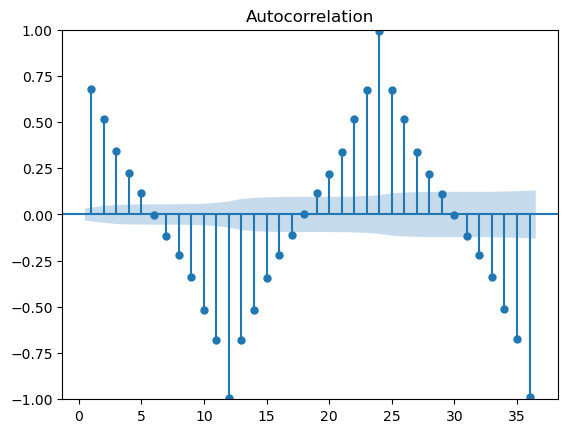

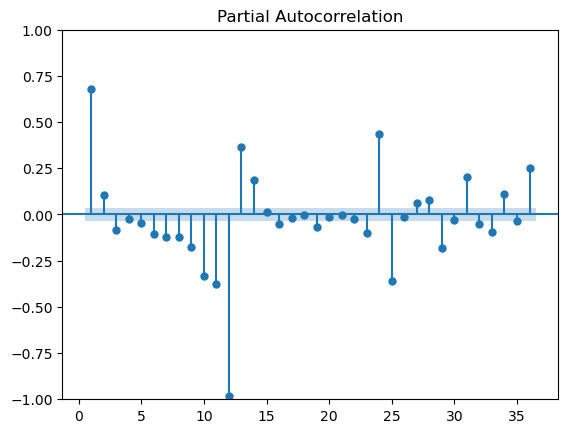

In [41]:
# Graficar ACF y PACF - > Analizar el caso cuando se diferencia la serie estacional seleccionada


Concluir...

## 3. Componente no estacional $(p, d, q)$

<AxesSubplot: xlabel='date'>

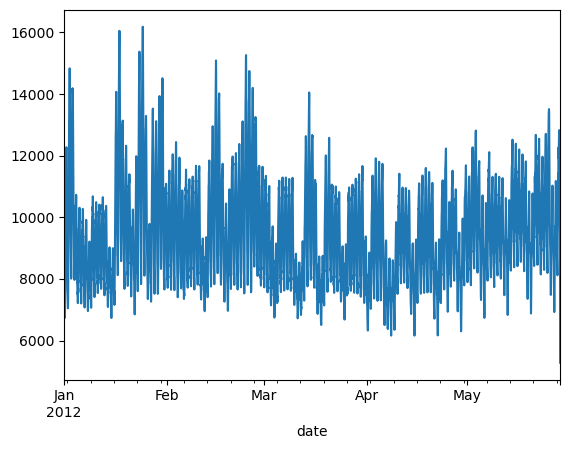

In [74]:
# Calcular la componente no estacional de la serie temporal
non_seasonal = 

non_seasonal.plot()

In [45]:
# Calcular si la serie no estacional es estacionaria o no
adf_test(non_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                -6.653967e+00
p-value                        5.038531e-09
#Lags Used                     2.800000e+01
Number of Observations Used    3.548000e+03
Critical Value (1%)           -3.432194e+00
Critical Value (5%)           -2.862355e+00
Critical Value (10%)          -2.567204e+00
dtype: float64
Stationary


## a). Analizar autocorrelación

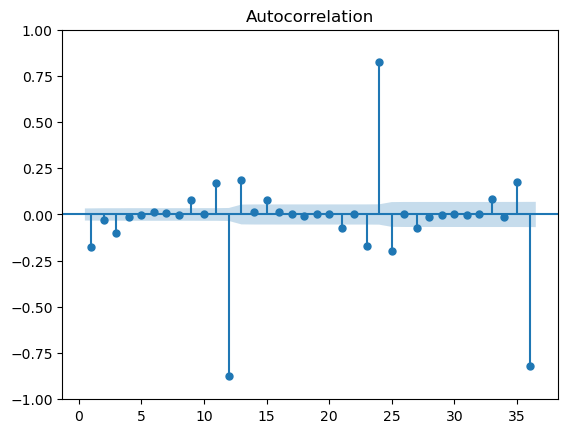

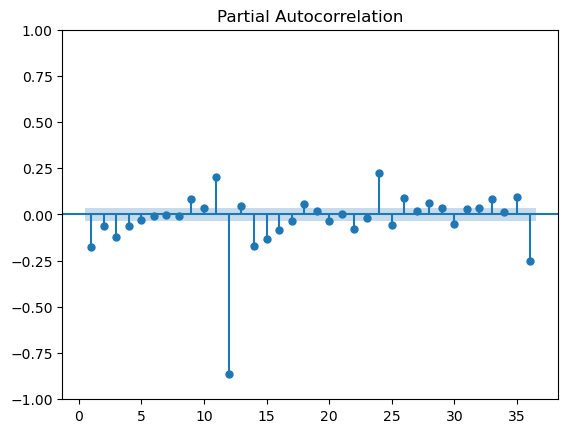

In [51]:
# Graficar ACF y PACF para obtener valores de p y q (analizar el efecto de diferenciar diff())


Concluir...

# Un poco de teoría de los modelos SARIMAX

Analicemos matemáticamente un modelo SARIMAX. Generalmente este modelo se escribe como un modelo ARIMA$(p,d,q) \times (P,D,Q)_s$, donde las letras minúsculas indican la especificación para el componente **no estacional** y las letras **mayúsculas** indican la especificación para el **componente estacional**; es la periodicidad de las estaciones (por ejemplo, suele ser 4 para datos trimestrales o 12 para datos mensuales). El proceso se puede escribir genéricamente como:
$$
\phi_p (L) \tilde \phi_P (L^s) \Delta^d \Delta_s^D y_t = A(t) + \theta_q (L) \tilde \theta_Q (L^s) \epsilon_t
$$
dónde:
- $\phi_p (L)$ es el polinomio de rezago autorregresivo no estacional
- $\tilde \phi_P (L^s)$ es el polinomio de retraso autorregresivo estacional
- $\Delta^d \Delta_s^D y_t$ es la serie temporal, los tiempos diferenciados y los diferenciados estacionalmente
- $A(t)$ es el polinomio de tendencia (incluida la intersección)
- $\theta_q (L)$ es el polinomio de rezago promedio móvil no estacional
- $\tilde \theta_Q (L^s)$ es el polinomio de retraso de la media móvil estacional

Consideremos como ejemplo el siguiente modelo ARIMA$(2,1,0)\times (1,1,0)_{12}$ con un intercepto. El proceso de datos se puede escribir en el formulario anterior como:
$$
(1 - \phi_1 L - \phi_2 L^2) (1 - \tilde \phi_1 L^{12}) \Delta \Delta_{12} y_t = c + \epsilon_t
$$

Considerando $y_t^* = \Delta \Delta_{12} y_t$ el modelo se puede reescribir de la siguiente forma:
$$
y_t^* = c + \phi_1 y_{t-1}^* + \phi_2 y_{t-2}^* + \tilde \phi_1 y_{t-12}^* - \phi_1 \tilde \phi_1 y_{t-13}^* - \phi_2 \tilde \phi_1 y_{t-14}^* + \epsilon_t.
$$

Si pensamos que nuestro modelo puede tener más de una valor $(p,d,q,P,D,Q)$ entonces una buena idea podría hacer una búsqueda exhaustiva en un espacio definido. Por ejemplo,

In [88]:
import itertools

# Posibles valores en lo que pueden variar los parámetros de un SARIMAX
# Parte no estacional
p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2]
# Parte estacional
P = [0, 1, 2]
D = [0, 1]
Q = [0, 1, 2]
# Tipo de tendencia
t = ['n', 'c', 't', 'ct']

# Explorar función itertools.product

# Diferentes conmbinaciones
sarimax_params = 

sarimax_params

[((0, 0, 0), (0, 0, 0, 12), 'n'),
 ((0, 0, 0), (0, 0, 0, 12), 'c'),
 ((0, 0, 0), (0, 0, 0, 12), 't'),
 ((0, 0, 0), (0, 0, 0, 12), 'ct'),
 ((0, 0, 0), (0, 0, 1, 12), 'n'),
 ((0, 0, 0), (0, 0, 1, 12), 'c'),
 ((0, 0, 0), (0, 0, 1, 12), 't'),
 ((0, 0, 0), (0, 0, 1, 12), 'ct'),
 ((0, 0, 0), (0, 0, 2, 12), 'n'),
 ((0, 0, 0), (0, 0, 2, 12), 'c'),
 ((0, 0, 0), (0, 0, 2, 12), 't'),
 ((0, 0, 0), (0, 0, 2, 12), 'ct'),
 ((0, 0, 0), (0, 1, 0, 12), 'n'),
 ((0, 0, 0), (0, 1, 0, 12), 'c'),
 ((0, 0, 0), (0, 1, 0, 12), 't'),
 ((0, 0, 0), (0, 1, 0, 12), 'ct'),
 ((0, 0, 0), (0, 1, 1, 12), 'n'),
 ((0, 0, 0), (0, 1, 1, 12), 'c'),
 ((0, 0, 0), (0, 1, 1, 12), 't'),
 ((0, 0, 0), (0, 1, 1, 12), 'ct'),
 ((0, 0, 0), (0, 1, 2, 12), 'n'),
 ((0, 0, 0), (0, 1, 2, 12), 'c'),
 ((0, 0, 0), (0, 1, 2, 12), 't'),
 ((0, 0, 0), (0, 1, 2, 12), 'ct'),
 ((0, 0, 0), (1, 0, 0, 12), 'n'),
 ((0, 0, 0), (1, 0, 0, 12), 'c'),
 ((0, 0, 0), (1, 0, 0, 12), 't'),
 ((0, 0, 0), (1, 0, 0, 12), 'ct'),
 ((0, 0, 0), (1, 0, 1, 12), 'n'),
 ((0, 0

# 4. Transformación/escalado de variable de interés

## a). Transformación logarítmica/sqtr

array([[<AxesSubplot: title={'center': 'y'}>]], dtype=object)

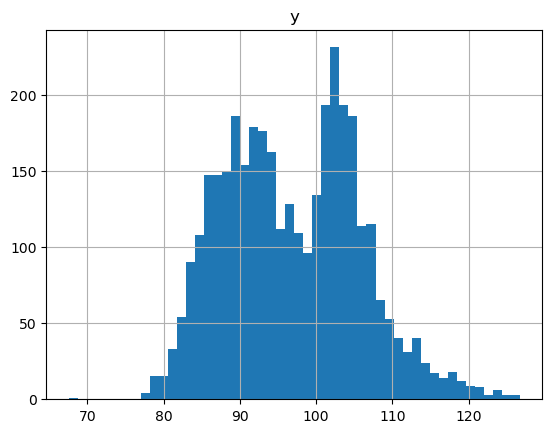

In [99]:
# Obtener histograma con la transformación logarítmica y sqrt


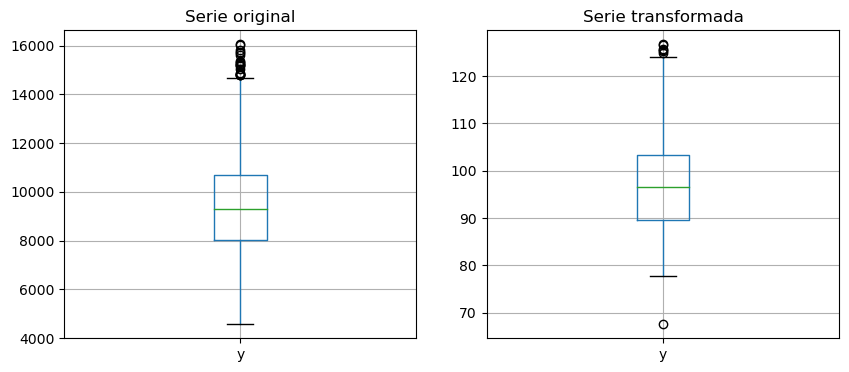

In [109]:
# Calcular el boxplot antes y después de la transformación
fig, ax = plt.subplots(1, 2, figsize=(10,4))
timeseries.boxplot(ax=ax[0])
ax[0].set_title('Serie original')


ax[1].set_title('Serie transformada')
plt.show()

## b). Transformación de box-cox, yeo-johnson

array([[<AxesSubplot: title={'center': 'box_cox'}>]], dtype=object)

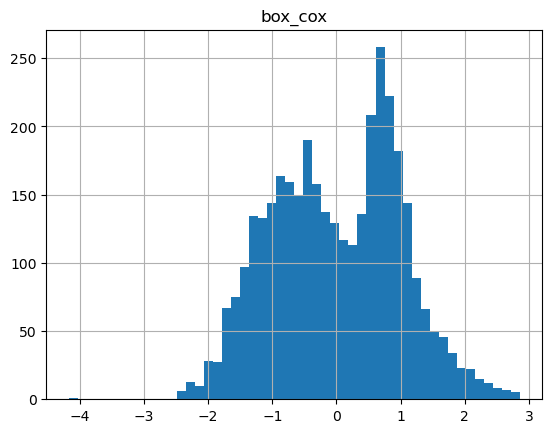

In [113]:
from sklearn.preprocessing import power_transform

vals_bc = power_transform(timeseries.to_numpy().reshape(-1, 1), method='box-cox')

transform_bc = pd.DataFrame({'box_cox': vals_bc.squeeze()})
transform_bc.hist(bins=50)

array([[<AxesSubplot: title={'center': 'yeo_johnson'}>]], dtype=object)

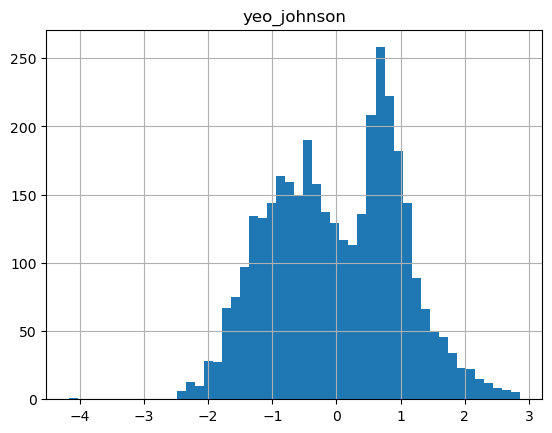

In [114]:
vals_yj = power_transform(timeseries.to_numpy().reshape(-1, 1), method='yeo-johnson')

transform_yj = pd.DataFrame({'yeo_johnson': vals_yj.squeeze()})
transform_yj.hist(bins=50)

## c). Escalado usando `MinMaxScaler` y `StandardScaler`

In [130]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest

# MinMaxScaler
mm_scaler = MinMaxScaler()
vals_mm = mm_scaler.fit_transform(timeseries)
vals_mm

array([[0.29248867],
       [0.29033783],
       [0.23408118],
       ...,
       [0.47518896],
       [0.45241439],
       [0.        ]])

array([[<AxesSubplot: title={'center': 'MinMaxScaler'}>]], dtype=object)

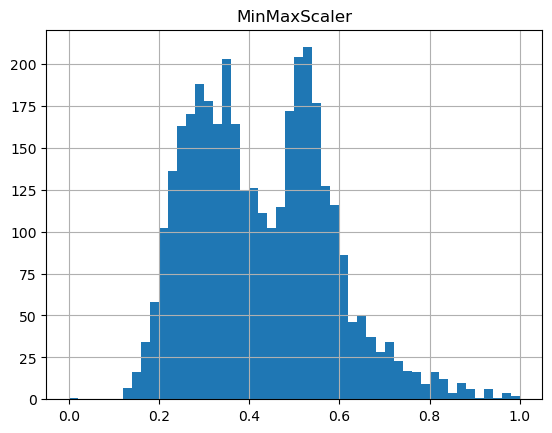

In [133]:
pd.DataFrame({'MinMaxScaler': vals_mm.squeeze()}).hist(bins=50)

array([[<AxesSubplot: title={'center': 'StandartScaler'}>]], dtype=object)

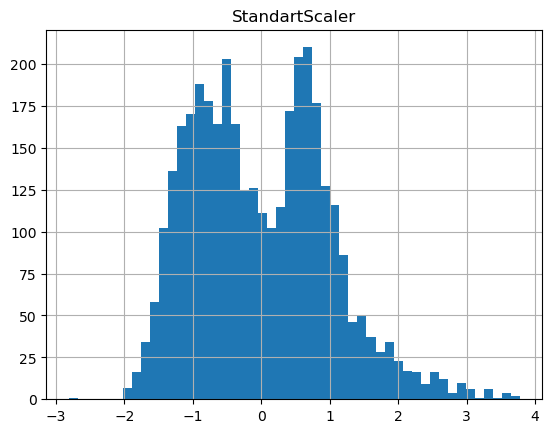

In [135]:
scaler = StandardScaler()
vals_ss = scaler.fit_transform(timeseries.values.reshape(-1, 1))
pd.DataFrame({'StandartScaler': vals_ss.squeeze()}).hist(bins=50)

# 5. Con los datos escalados encontrar el conjunto más adecuado de parámetros

In [ ]:
# encuentre el 'conjunto más adecuado' de parámetros no estacionales y estacionales

mod = SARIMAX(
    endog=,
    trend=,
    order=,
    seasonal_order=
)
results = mod.fit()

print(f'AIC={results.aic}', f'BIC={results.bic}', f'Log-likelihood={results.llf}', sep='\n')

In [ ]:
# Luego de encontrar el conjunto más óptimo de parámetros ajustar de nuevo el modelo y adicionalmente poner 
# el parámetro de entrada enforce_stationary=True y enforce_invertibility=True (valor por defecto) a False.
# Finalmente llamar el método plot_diagnostics() para analizar la distribución de los residuos

**Parámetros de SARIMAX**
- `dynamic`: También podemos obtener predicciones dinámicas `dynamic=True`. La predicción de un paso adelante utiliza los valores reales de los valores endógenos en cada paso para predecir el siguiente valor dentro de la muestra. Las predicciones dinámicas utilizan la predicción de un paso adelante hasta algún punto del conjunto de datos (especificado por el argumento dinámico); después de eso, los valores endógenos predichos anteriores se usan en lugar de los valores endógenos verdaderos para cada nuevo elemento predicho.
- Si tiene `enforce_stationary=True` y `enforce_invertibility=True` (los valores predeterminados), entonces no es posible obtener un modelo no estacionario/no invertible.
    Si los establece en False, simplemente devolvemos los resultados, ya sea que sean estacionarios/invertibles o no.

In [164]:
# Explorar el método predict
results.predict(timeseries.shape[0], timeseries.shape[0])

2012-05-29 01:00:00    2352.325816
Freq: H, dtype: float64

In [152]:
# Explorar el método get_forecast y su método conf_int() y atributo predicted_mean
forecast = results.get_forecast()

forecast.conf_int(), forecast.predicted_mean

(                        lower y      upper y
 2012-05-29 01:00:00  1613.31602  3091.335613,
 2012-05-29 01:00:00    2352.325816
 Freq: H, dtype: float64)

In [201]:
# Interactuar con las gráficas
%matplotlib widget

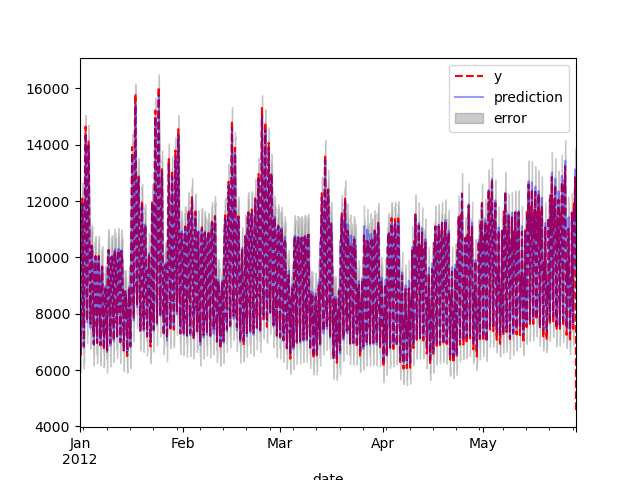

In [209]:
# Explorar el método get_prediction y su método conf_int(), y atributo predicted_mean
# y graficar el error de predicción, la media de predicción y los datos observados
import datetime

prediction = results.get_prediction()


<AxesSubplot: >

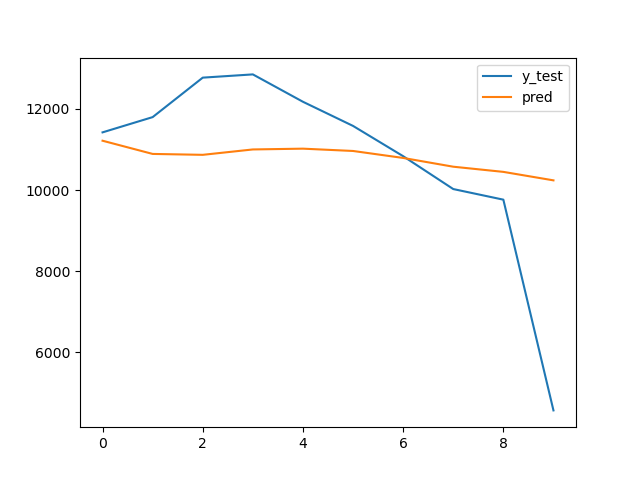

In [237]:
# Particionar la serie de tiempo en train y test y entrenar el modelo iterativamente usando un horizonte
# de predicción. En cada paso de entrenamiento adicionar los valores nuevos del conjunto de test a train
horizonte = 10
y_train =
y_test = 

y_pred = []

for i in range(horizonte):


pd.DataFrame({'y_test': y_test, 'pred':y_pred}).plot()

# 6. Calcular métricas de errores

$$
MAPE = \frac{1}{n}\sum_{t=1}^n \bigg|\frac{\text{Actual - Forecast}}{\text{Actual}}\bigg|
$$
y la desviación absoluta media (MAD)
$$
MAD = \frac{1}{n}\sum_{t=1}^n \big|\text{Actual - Forecast} \big|.
$$


# <font color= Red> Tarea 3

Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

In [ ]:
class LinearForecast:
    def __init__(self, atributos_del_contructor):
        
    def adf_test(self):
        
    def plot_acf_pac(self):
        
        .
        .
        .

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Zuluaga.
</footer>